I tried a hybrid model in this project. In this technique, first I used a custom ViT (Vision Transformer) model for the feature extraction stage, then applied PCA for the curse of dimensionality problem, and finally used a CatBoost model for the classification stage.

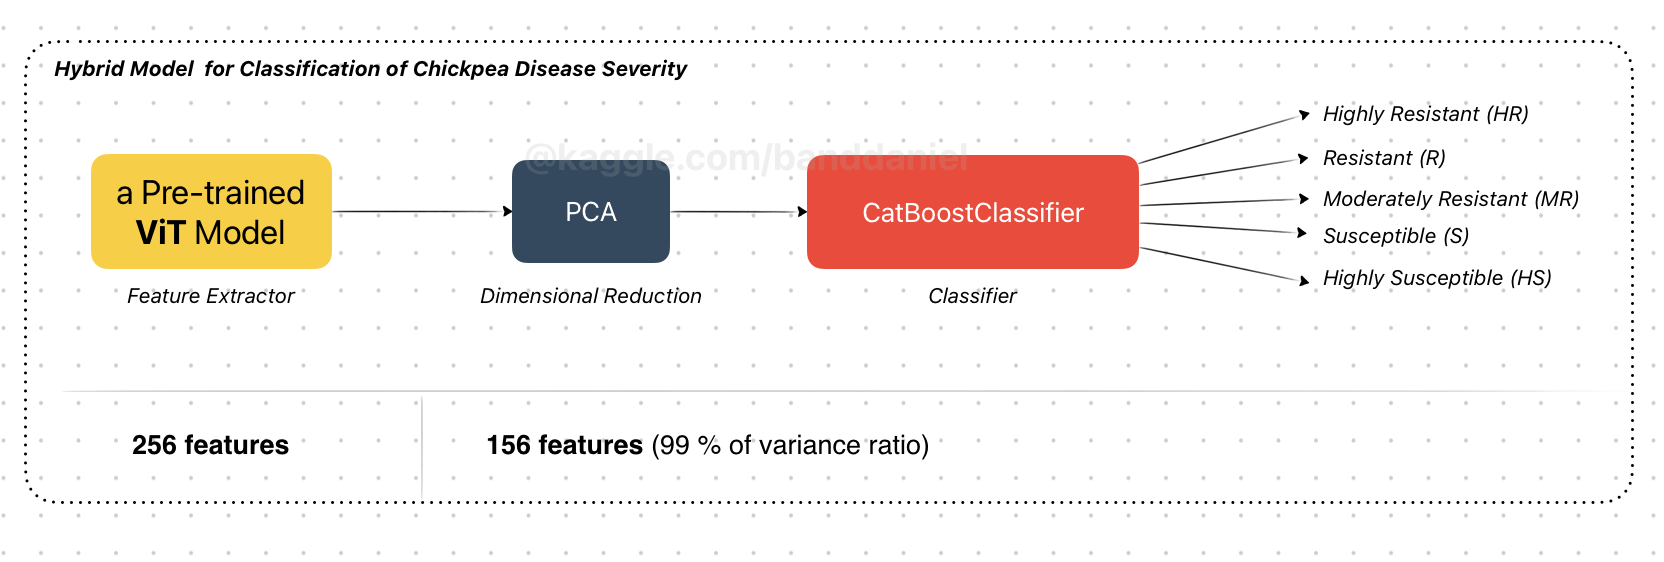

* The project took place using Google TPU,
* I used a customized ViT model [1],
* Used <b>tf.data</b> for input pipeline,
* I used a CatBoost model for classification,


## My Another Projects
* [Chest X-Ray Classification w/ViT (F1 Score: 0.9)](https://www.kaggle.com/code/banddaniel/chest-x-ray-classification-w-vit-f1-score-0-9)
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Bladder Tissue Classification w/ViT (F1 Scr: 0.82)](https://www.kaggle.com/code/banddaniel/bladder-tissue-classification-w-vit-f1-scr-0-82)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)


## References
1. https://github.com/faustomorales/vit-keras

In [1]:
from IPython.display import clear_output
!pip install vit_keras
!pip install catboost
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from vit_keras import vit

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model

from catboost import CatBoostClassifier

IMG_SIZE = 224, 224
BATCH_SIZE = 64
SEED = 22
AUTO = tf.data.AUTOTUNE

In [3]:
# Connecting TPU and creating strategy and the model

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

stg = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


HR_images = create_images_list('/kaggle/input/fusarium-wilt-disease-in-chickpea-dataset/FUSARIUM-22/dataset_raw/1(HR)')
R_images = create_images_list('/kaggle/input/fusarium-wilt-disease-in-chickpea-dataset/FUSARIUM-22/dataset_raw/3(R)')
MR_images = create_images_list('/kaggle/input/fusarium-wilt-disease-in-chickpea-dataset/FUSARIUM-22/dataset_raw/5(MR)')
S_images = create_images_list('/kaggle/input/fusarium-wilt-disease-in-chickpea-dataset/FUSARIUM-22/dataset_raw/7(S)')
HS_images = create_images_list('/kaggle/input/fusarium-wilt-disease-in-chickpea-dataset/FUSARIUM-22/dataset_raw/9(HS)')


# look-up table
classes = {0:'Highly Resistant (HR)', 1 : 'Resistant (R)', 2 :'Moderately Resistant (MR)', 3 :'Susceptible (S)', 4:'Highly Susceptible (HS)'}


full_data = pd.concat([pd.DataFrame({'img': HR_images, 'label':0}),
                       pd.DataFrame({'img': R_images, 'label':1}),
                       pd.DataFrame({'img': MR_images, 'label':2}),
                       pd.DataFrame({'img': S_images, 'label':3}),
                       pd.DataFrame({'img': HS_images, 'label':4}) ], ignore_index = True)


train_data, test_data = train_test_split(full_data, test_size = 0.2, stratify = full_data['label'], random_state = SEED)
train_data, val_data = train_test_split(train_data, test_size = 0.15, stratify = train_data['label'], random_state = SEED)

train_data = train_data.reset_index(drop = True)
val_data = val_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)


print("train images -> ", train_data.shape[0])
print("val images -> ", val_data.shape[0])
print("test images -> ", test_data.shape[0])

train_data.head()

train images ->  2950
val images ->  521
test images ->  868


img  label
0  /kaggle/input/fusarium-wilt-disease-in-chickpe...      4
1  /kaggle/input/fusarium-wilt-disease-in-chickpe...      2
2  /kaggle/input/fusarium-wilt-disease-in-chickpe...      2
3  /kaggle/input/fusarium-wilt-disease-in-chickpe...      3
4  /kaggle/input/fusarium-wilt-disease-in-chickpe...      2

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(img, label):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, dtype = tf.float32) / 255.0

    return img, label
    
# Data augmentation 
def augmentation(img, label):
    img = tf.image.random_flip_left_right(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 4, seed = SEED)
    
    return img, label

In [6]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_data['img'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*20)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# Training dataset without shuffling and data augmantation operations for the classification stage
train_dataset_feature = (train_loader
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTO))

val_loader = tf.data.Dataset.from_tensor_slices((val_data['img'], val_data['label']))
val_dataset = (val_loader
               .map(img_preprocessing, num_parallel_calls = AUTO)
               .map(augmentation, num_parallel_calls = AUTO)
               .shuffle(BATCH_SIZE*20)
               .batch(BATCH_SIZE)
               .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['img'], test_data['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#3498db;"> Feature Extraction </span>

# <span style="color:#e74c3c;"> Pretrained ViT Model Feature Extractor </span>

In [7]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax',
                            pretrained = True, include_top = False,
                            pretrained_top = False, classes = 5)

    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(256, activation = 'gelu', name = 'the_feature_layer')(X)
    X = Dense(128, activation = 'gelu')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(5, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.00001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc")]  )

2023-12-19 18:03:13.567570: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:13.567694: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 256)               196864    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                            

In [8]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, epochs = 25, batch_size = BATCH_SIZE, validation_data = val_dataset)
model.save("vit_feature_extractor.h5")

2023-12-19 18:03:32.212484: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:32.230799: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:32.248945: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:32.265710: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:32.283179: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:32.300373: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:03:32.318442: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/25


2023-12-19 18:04:04.438521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-12-19 18:04:09.319312: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:04:09.322611: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:04:09.326333: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:04:09.326482: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:04:09.326642: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:04:09.327501: E ./tensorflow/compiler/xla/stream_executor/s

 2/47 [>.............................] - ETA: 6s - loss: 1.6907 - acc: 0.2500 - top_3_acc: 0.6406     

2023-12-19 18:05:02.109416: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:05:02.109556: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:05:02.250168: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


34/47 [====================>.........] - ETA: 1s - loss: 1.1424 - acc: 0.4871 - top_3_acc: 0.9076

2023-12-19 18:05:06.022032: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


47/47 [==============================] - ETA: 0s - loss: 1.0589 - acc: 0.5278 - top_3_acc: 0.9295

2023-12-19 18:05:57.331459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-19 18:05:58.646804: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


47/47 [==============================] - 159s 2s/step - loss: 1.0589 - acc: 0.5278 - top_3_acc: 0.9295 - val_loss: 0.9140 - val_acc: 0.6046 - val_top_3_acc: 0.9712
Epoch 2/25
31/47 [==================>...........] - ETA: 1s - loss: 0.8098 - acc: 0.6260 - top_3_acc: 0.9808

2023-12-19 18:06:17.138919: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


47/47 [==============================] - ETA: 0s - loss: 0.7871 - acc: 0.6431 - top_3_acc: 0.9824

2023-12-19 18:06:20.166951: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


47/47 [==============================] - 8s 148ms/step - loss: 0.7871 - acc: 0.6431 - top_3_acc: 0.9824 - val_loss: 0.7573 - val_acc: 0.6833 - val_top_3_acc: 0.9750
Epoch 3/25
47/47 [==============================] - ETA: 0s - loss: 0.6936 - acc: 0.7003 - top_3_acc: 0.9925

2023-12-19 18:06:28.600728: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


47/47 [==============================] - 8s 149ms/step - loss: 0.6936 - acc: 0.7003 - top_3_acc: 0.9925 - val_loss: 0.6629 - val_acc: 0.7083 - val_top_3_acc: 0.9904
Epoch 4/25
47/47 [==============================] - 8s 150ms/step - loss: 0.5831 - acc: 0.7539 - top_3_acc: 0.9942 - val_loss: 0.6457 - val_acc: 0.7390 - val_top_3_acc: 0.9923
Epoch 5/25
47/47 [==============================] - 8s 147ms/step - loss: 0.4770 - acc: 0.7966 - top_3_acc: 0.9980 - val_loss: 0.6243 - val_acc: 0.7294 - val_top_3_acc: 0.9942
Epoch 6/25
47/47 [==============================] - 8s 148ms/step - loss: 0.4290 - acc: 0.8298 - top_3_acc: 0.9983 - val_loss: 0.8034 - val_acc: 0.6987 - val_top_3_acc: 0.9923
Epoch 7/25
47/47 [==============================] - 8s 149ms/step - loss: 0.3354 - acc: 0.8725 - top_3_acc: 0.9990 - val_loss: 0.7620 - val_acc: 0.6910 - val_top_3_acc: 0.9866
Epoch 8/25
47/47 [==============================] - 8s 150ms/step - loss: 0.2753 - acc: 0.8936 - top_3_acc: 0.9986 - val_loss: 0.68

In [9]:
# Validation and Test evaluations of ViT model

with stg.scope():
    print('ViT model results')
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

ViT model results
----------------------------------------------------------------------------------------------------
14/14 [==============================] - 9s 572ms/step - loss: 1.2029 - acc: 0.7362 - top_3_acc: 0.9862
Test Loss: 1.203
Test Accuracy: 73.618 %


# <span style="color:#e74c3c;"> Classification </span> Stage

In [10]:
# Reading saved model and weights
feature_extr = tf.keras.models.load_model('/kaggle/working/vit_feature_extractor.h5')

# Feature extraction model 
feature_extractor_model = Model(inputs=feature_extr.input,
                                outputs=feature_extr.get_layer('the_feature_layer').output)

In [11]:
# Creating train features

with stg.scope():
    features = feature_extractor_model.predict(train_dataset_feature)

2023-12-19 18:09:54.564754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


 1/47 [..............................] - ETA: 22:26

2023-12-19 18:10:20.235786: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.235941: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.236030: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.236085: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.236174: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.236267: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.236340: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 2/47 [>.............................] - ETA: 16s  

2023-12-19 18:10:20.602829: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.602956: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.603023: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.603114: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.603188: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.603259: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.604527: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 3/47 [>.............................] - ETA: 16s

2023-12-19 18:10:20.956134: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.956229: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.956304: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.956376: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.956433: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.956519: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:20.956596: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 4/47 [=>............................] - ETA: 15s

2023-12-19 18:10:21.324279: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.326486: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.326717: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.327050: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.328644: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.328915: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.329326: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 5/47 [==>...........................] - ETA: 15s

2023-12-19 18:10:21.684161: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.684259: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.686280: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.687429: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.687529: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.687627: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:21.687714: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 6/47 [==>...........................] - ETA: 14s

2023-12-19 18:10:22.040225: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.041886: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.042926: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.043466: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.043566: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 7/47 [===>..........................] - ETA: 14s

2023-12-19 18:10:22.413114: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.413243: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.413323: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.413410: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.413522: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.413608: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.413716: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 8/47 [====>.........................] - ETA: 14s

2023-12-19 18:10:22.778799: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.781011: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.781115: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.781196: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.781279: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.781376: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:22.781697: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 9/47 [====>.........................] - ETA: 13s

2023-12-19 18:10:23.131369: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:23.131646: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-19 18:10:23.132979: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


10/47 [=====>........................] - ETA: 13s

2023-12-19 18:10:23.491063: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


47/47 [==============================] - 70s 892ms/step


# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [12]:
# Applying PCA 156 components nearly equal to 0.99 variance ratio

pca_ = PCA(156)
pred_pca_ = pca_.fit(features)
pred_pca = pred_pca_.transform(features)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
train_features = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with a ViT feature extractor 
train_features.head()

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -8.724653  16.128382 -10.070083  -5.746409  -0.548428  -0.181213   
1  -7.285614 -10.090356   5.065691  -3.532474  -0.992967  -1.054706   
2 -10.556360  -9.707388   5.706719  -1.582196  -2.938472  -1.615946   
3 -16.001848   5.225103  -3.803809   6.580933   2.712419  -2.479527   
4  -9.655169  -8.571279   5.121185  -2.566703  -4.312345  -1.634130   

   feature_7  feature_8  feature_9  feature_10  ...  feature_147  feature_148  \
0   0.457945  -0.261549  -0.146915    1.359077  ...    -0.108598     0.015835   
1  -0.812600   0.337777  -0.021028   -1.449232  ...    -0.239889     0.271148   
2  -0.873958  -0.106710   1.574368    1.269209  ...     0.308485    -0.428178   
3  -2.094177   0.098251  -1.291884   -1.778057  ...     0.275119    -0.144806   
4  -0.454227   0.792796   1.786337    0.718000  ...     0.067341    -0.087965   

   feature_149  feature_150  feature_151  feature_152  feature_153  \
0    -0.191665     0.038660    -0.179096    -0.151472    -0.144172   
1     0.086173     0.011314    -0.046517     0.062282    -0.173080   
2     0.466423    -0.468322    -0.132026    -0.211663     0.120856   
3    -0.037859     0.349699    -0.046875     0.130665    -0.038140   
4     0.107794    -0.098010     0.218165    -0.126942     0.365341   

   feature_154  feature_155  feature_156  
0     0.090456    -0.007201    -0.028039  
1     0.037102     0.180363    -0.246194  
2    -0.061303    -0.042200     0.052821  
3    -0.229876    -0.014707     0.129646  
4    -0.133713     0.214671     0.106728  

[5 rows x 156 columns]

# <span style="color:#e74c3c;"> Classification with CatBoost </span> Model

In [13]:
X_train = train_features
y_train =  train_data['label']

# CatBoostClassifier model
cat_model = CatBoostClassifier(verbose = 250)

# Training CatBoostClassifier model with features from the ViT feature extractor
cat_model.fit(X_train, y_train)

Learning rate set to 0.083615
0:	learn: 1.3829564	total: 80.1ms	remaining: 1m 19s
250:	learn: 0.0693589	total: 3.43s	remaining: 10.2s
500:	learn: 0.0375292	total: 6.77s	remaining: 6.74s
750:	learn: 0.0237981	total: 10.1s	remaining: 3.35s
999:	learn: 0.0161449	total: 13.5s	remaining: 0us


In [14]:
# Test set processing
# test feature exteaction -> applying PCA -> predictions of the CatBoostClassifier model

with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_features = pca_.transform(test_features)
test_features = pd.DataFrame(test_features, columns = new_feature_column_names)

X_test = test_features
y_test = test_data['label']

test_pred = cat_model.predict(X_test)

14/14 [==============================] - 31s 2s/step


# <span style="color:#e74c3c;"> Test  </span> Results

In [15]:
# Predictions and scores

mse = mean_squared_error(y_test, test_pred)
f1 = f1_score(y_test, test_pred, average = 'weighted')
acc = accuracy_score(y_test, test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

Mean Squared Error : 0.35714
Weighted F1 Score : 0.752
Accuracy Score : 75.115 %


# <span style="color:#e74c3c;"> Test Classification </span> Report

In [16]:
# classification report

clf_report = classification_report(y_test, test_pred, target_names = list(classes.values()))
print(clf_report)

                           precision    recall  f1-score   support

    Highly Resistant (HR)       0.81      0.73      0.77       192
            Resistant (R)       0.72      0.74      0.73       235
Moderately Resistant (MR)       0.69      0.74      0.71       227
          Susceptible (S)       0.68      0.69      0.68       112
  Highly Susceptible (HS)       0.96      0.90      0.93       102

                 accuracy                           0.75       868
                macro avg       0.77      0.76      0.77       868
             weighted avg       0.76      0.75      0.75       868



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

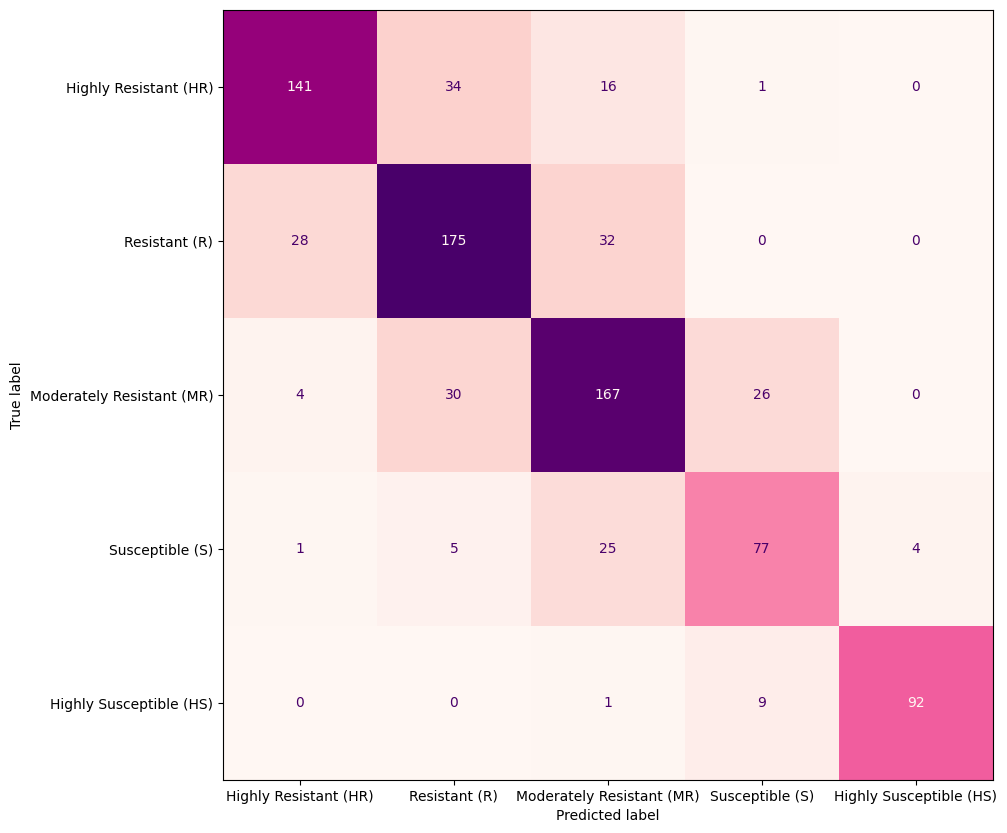

In [17]:
cm = confusion_matrix(y_test, test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values())) 

fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap = 'RdPu', colorbar = False)

 # <span style="color:#e74c3c;"> Test Sample</span> Prediction

In [18]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

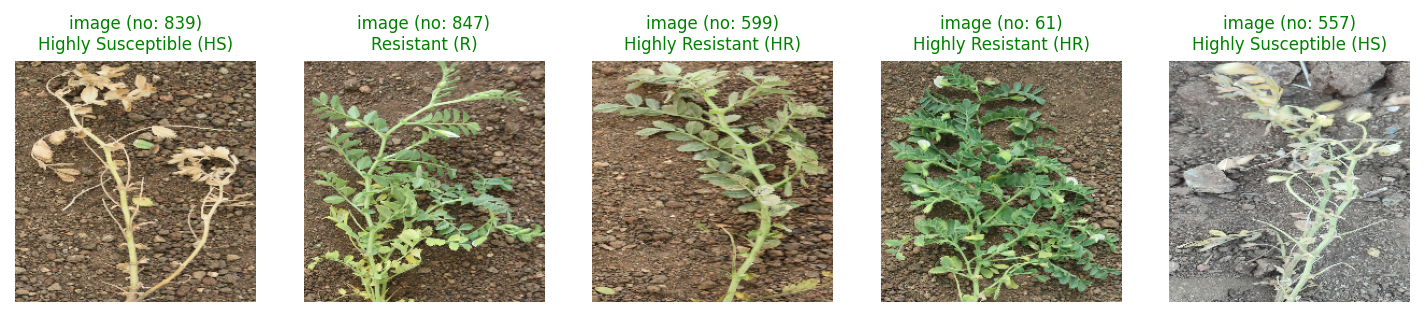

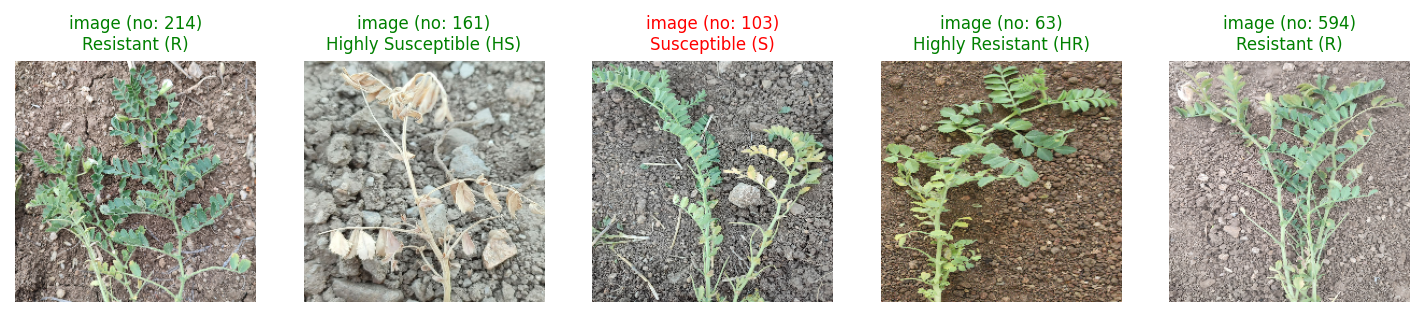

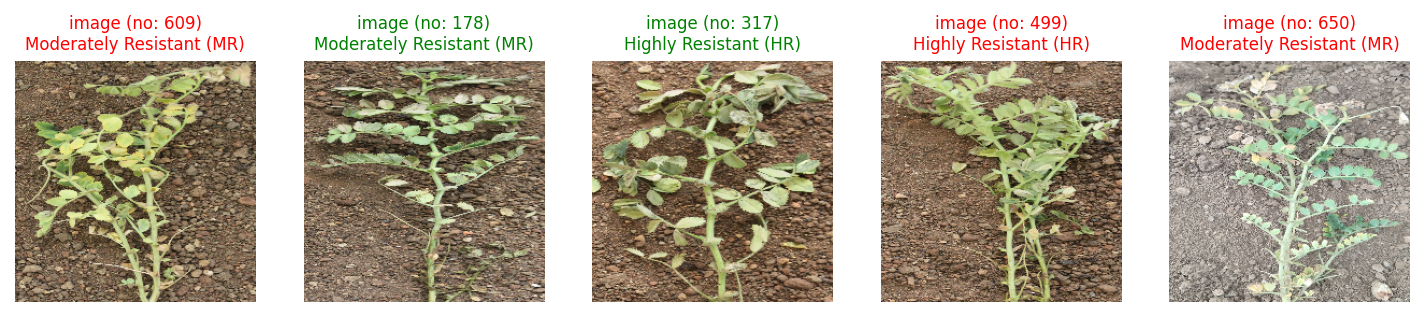

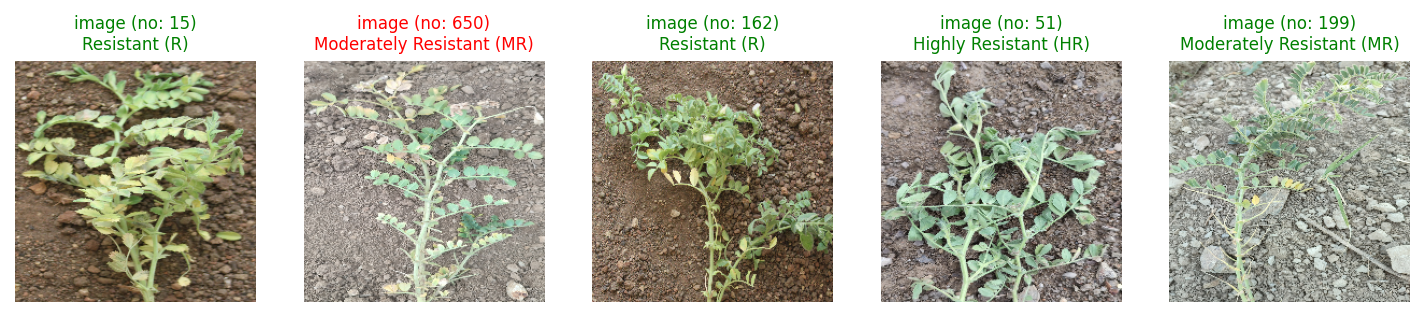

In [19]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 5)
random_test_sample_with_prediction(SEED = 641)
random_test_sample_with_prediction(SEED = 36)
random_test_sample_with_prediction(SEED = 24)